In [2]:
import pandas as pd
import sys, os, re
import warnings
import numpy as np
from tqdm import tqdm
import pickle
from config import *

sys.path.append(f"{ROOT}")
PATH = "/home/malbranke/mutation_data"
warnings.filterwarnings("ignore")

In [3]:
from data_extraction.utils import *

In [4]:
data = pickle.load(open(f"{DATA}/secondary_structure/training_set", "rb"))

In [29]:
bboxes = []
for _, sse in tqdm(data.values()):
    ss = to_onehot(sse, (None, 3))
    ss = np.pad(ss, ((1, 1), (0, 0)), "constant")
    dss = (ss[1:] - ss[:-1])
    cls = to_onehot(np.where(dss == -1)[1], (None, 3)).T
    bbox = np.array([np.where(dss == 1)[0], np.where(dss == -1)[0], *cls]).T
    bboxes.append(bbox)

100%|██████████| 8678/8678 [00:00<00:00, 8738.56it/s]


In [30]:
pi = np.zeros(4)
pi[:3] = np.array([x[0, 2:] for x in bboxes]+[x[-1, 2:] for x in bboxes]).sum(0)

In [31]:
T_ = [np.append(x[:-1, 2:],x[1:, 2:], axis = 1) for x in bboxes]
T_ = np.concatenate(T_, axis = 0)

T = np.zeros((4,4))
for i in range(3):
    t = T_[np.where(T_[:,i] == 1)[0], 3:]
    T[i,:3] = t.sum(0)
    T[i,3] = pi[i]
    T[i] /= T[i].sum() 
T[3,3] = 1
T = T.reshape(4,4,1,1)

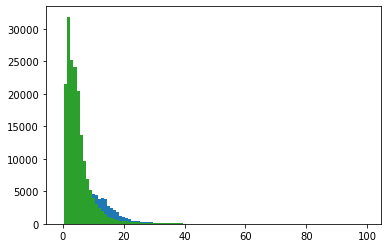

In [32]:
bboxes_sp = [np.concatenate([x[np.where(x[:, 2]==1)[0]][:, :2] for x in bboxes], axis=0),
             np.concatenate([x[np.where(x[:, 3]==1)[0]][:, :2] for x in bboxes], axis=0),
             np.concatenate([x[np.where(x[:, 4]==1)[0]][:, :2] for x in bboxes], axis=0)]

Q_ = np.zeros((3, 100))
for i in range(3):
    Q_[i] = plt.hist(bboxes_sp[i][:,1] - bboxes_sp[i][:,0], bins = np.linspace(0, 100, 101)-0.5)[0]
    Q_[i] /= Q_[i].sum()

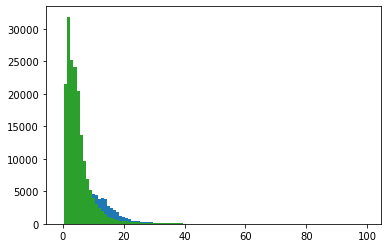

In [33]:
Q = np.zeros((4,500,500))

for j in range(500):
    Q[:3,j, j:min(j+100, 500)] = Q_[:, :min(j+100, 500)-j]
Q[3, np.arange(500), np.arange(500)] = 1
Q = Q.reshape((1,4,500,500))

In [34]:
Q = torch.tensor(np.log(Q)+np.log(T))
pi = torch.tensor(np.log(pi/pi.sum()).reshape(-1,1))

torch.save(pi, "pi.pt")
torch.save(Q, "Q.pt")

In [36]:
Q

tensor([[[[    -inf,     -inf,     -inf,  ...,     -inf,     -inf,     -inf],
          [    -inf,     -inf,     -inf,  ...,     -inf,     -inf,     -inf],
          [    -inf,     -inf,     -inf,  ...,     -inf,     -inf,     -inf],
          ...,
          [    -inf,     -inf,     -inf,  ...,     -inf,     -inf,     -inf],
          [    -inf,     -inf,     -inf,  ...,     -inf,     -inf,     -inf],
          [    -inf,     -inf,     -inf,  ...,     -inf,     -inf,     -inf]],

         [[    -inf,  -4.8210,  -5.4116,  ...,     -inf,     -inf,     -inf],
          [    -inf,     -inf,  -4.8210,  ...,     -inf,     -inf,     -inf],
          [    -inf,     -inf,     -inf,  ...,     -inf,     -inf,     -inf],
          ...,
          [    -inf,     -inf,     -inf,  ...,     -inf,  -4.8210,  -5.4116],
          [    -inf,     -inf,     -inf,  ...,     -inf,     -inf,  -4.8210],
          [    -inf,     -inf,     -inf,  ...,     -inf,     -inf,     -inf]],

         [[    -inf,  -2.1650,

In [20]:
import sys
import warnings
from config import *

DATASET = "PF00397"
sys.path.append(f"{ROOT}")

warnings.filterwarnings("ignore")

In [23]:
import numpy as np
import pickle
import pandas as pd
from random import shuffle
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader

from ss_inference.data import SecondaryStructureRawDataset, collate_sequences
from ss_inference.model import NetSurfP2, ConvNet

from pattern_matching.graphics import visualize_secondary_structure
from pattern_matching.utils import *
from pattern_matching.loss import PatternMatchingLoss
from pattern_matching.pattern import Matching

from pgm.data import SequenceData

from config import DATA

import torch
import torch.nn as nn
import torch.nn.functional as F

inf = float("Inf")


torch.cuda.is_available()

True

In [202]:
dataset = SequenceData(f"{DATA}/{DATASET}", dataset="full")
loader = DataLoader(dataset, batch_size = 100, 
                          shuffle = False)

device = "cuda"

model_ss3 = NetSurfP2(50, "nsp2")
model_ss3 = model_ss3.to(device)
model_ss3.load_state_dict(torch.load(f"{DATA}/secondary_structure/lstm_50feats.h5"))
model_ss3

Model nsp2-50

In [38]:
pi

tensor([[-inf],
        [-inf],
        [0.],
        [-inf]], dtype=torch.float64)

In [273]:
size = 50
Q = torch.load("Q.pt").float()
pi = torch.load("pi.pt")[:,0].float()

seq_hmm = torch.tensor(dataset[0][3]).t()[20:]
torch.save(seq_hmm, f"{DATA}/{DATASET}/hmm.pt")
_, size = seq_hmm.size()

matcher = PatternMatchingInference(model_ss3, Q = Q, pi = pi,
                          seq_hmm = seq_hmm, size = size)

In [286]:
p = []
for batch_idx, data in tqdm(enumerate(loader)):
    x = data[0].permute(0,2,1).float()
    torch.cuda.empty_cache()
    m = Matching(x)
    p_ = matcher(m, 4)
    p.append(p_)
    if batch_idx == 30:
        break
p = torch.cat(p,0)

30it [00:13,  2.17it/s]


In [271]:
class PatternMatchingInference(nn.Module):

    def __init__(self, model_ss3, Q, pi, seq_hmm, size=68, name=""):
        super(PatternMatchingInference, self).__init__()
        self.name = f"Matcher {name}"
        self.size = size
        Q = torch.tensor(Q[:, :, :size + 1, :size + 1]).float()
        self.Q = Q.view(1, *Q.size())
        self.pi = pi.view(1, *pi.size())
        self.model_ss3 = model_ss3
        self.SEQ_HMM = seq_hmm
        self.do_match = True

    def __repr__(self):
        return self.name

    def forward(self, m:Matching, T):
        batch_size = m.batch_size
        hmm, m.ls = self.hmm_(m)
        hmm = hmm.to(self.model_ss3.device)
        m.ss3 = F.softmax(self.model_ss3(hmm)[2].cpu(),1).detach()+1e-3
        m.P = self.P_(m).float()
        m.a = self.max_alpha(m,T)
        return self.argmax_alpha(m,T)

    def max_alpha(self, m, T):
        batch_size, P, ls = m.batch_size, m.P, m.ls
        alpha, norm = [], []
        a_ = -torch.ones(batch_size, 4, self.size+1)*inf
        a_[:,:,0] = self.pi
        n_ = a_.logsumexp((-1,-2), keepdim = True)
        a_ -= n_
        alpha.append(a_), norm.append(n_)
        last_a, last_n = a_[:,:,None,:,None], n_
        for i in range(self.size):
            a_ = (P + T*self.Q + last_a).max(-4)[0].max(-2)[0]
            n_ = last_n + a_.logsumexp((-1,-2), keepdim = True)
            a_ = a_ + last_n - n_
            alpha.append(a_), norm.append(n_)
            last_a, last_n = a_[:,:,None,:,None], n_
        alpha = torch.cat([a_[:,None] for a_ in alpha[::-1]], 1)
        norm = torch.cat([n_[:,None] for n_ in norm], 1)
        return alpha + norm
    
    def argmax_alpha(self, m, T):
        alpha = m.a
        size = alpha.size(-1)
        batch_size, P, ls = m.batch_size, m.P, m.ls
        c_star, t_star = torch.ones(batch_size).long()*3, ls
        max_pattern = [torch.cat([c_star.view(-1,1), t_star.view(-1,1)],1)]

        for a in alpha.transpose(1,0)[1:]:
            a_ = (P[torch.arange(batch_size),:,c_star,:, t_star] + T*self.Q.expand(batch_size,-1,-1,-1,-1)[torch.arange(batch_size),:,c_star,:,t_star]+a).view(batch_size, -1).argmax(-1)
            c_star, t_star = a_//size, a_%size
            max_pattern.append(torch.cat([c_star.view(-1,1), t_star.view(-1,1)],1))
        max_pattern = torch.cat([p[:,None] for p in max_pattern[::-1]], 1)
        return max_pattern

    def hmm_(self, m):
        batch_size, x = m.batch_size, m.x
        hmm = torch.zeros(batch_size, 20 + self.SEQ_HMM.size(0), self.size)
        ls = []
        for i, x_ in zip(range(batch_size), x):
            idx = torch.where(x_[0] == 0)[0]
            n_idx = idx.size(0)
            ls.append(n_idx)
            hmm[i, :20, :n_idx] = x_[:20, idx]
            hmm[i, 20:, :n_idx] = self.SEQ_HMM[:, idx]
        ls = torch.tensor(ls)
        return hmm, ls

    def P_(self, m):
        batch_size, C, ls = m.batch_size, torch.log(m.ss3), m.ls
        P = torch.zeros(batch_size, 4, self.size + 1, self.size + 1)
        for i in range(self.size+1):
            P[:, :3, i, :i + 1] = -inf
            if i == self.size:
                break
            P[:, :3, :i + 1, i + 1:] += C[:, :, i].view(batch_size, 3, 1, 1)
        P[:,3] = -inf
        P[:,3, ls, ls] = 0 
        return P[:,None,:,:,:]
